# Fast translation: Alboussiere et al. 2010

In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
from mpl_toolkits.basemap import Basemap #to render maps
import math

import GrowYourIC
from GrowYourIC import positions, geodyn, geodyn_trg, geodyn_static, plot_data, data


plt.rcParams['figure.figsize'] = (8.0, 3.0) #size of figures
cm = plt.cm.get_cmap('viridis')
cm2 = plt.cm.get_cmap('winter')

In the case of fast translation, the point is 
- to compare with results from Geballe 2013
- to look at the spatial repartition of data
- can we inverse for obtaining the direction of the translation axis?

## Parameters

In [2]:
age_ic_dim = 1e9 #in years
rICB_dim = 1221. #in km
translation_velocity_dim = 4e-10 #m.s, value for today's Earth with Q_cmb = 10TW (see Alboussiere et al. 2010)
time_translation = rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)
maxAge = 2.*time_translation/1e6
print("The translation recycles the inner core material in {0:.2f} million years".format(maxAge))
print("Translation velocity is {0:.2e} km/years".format(translation_velocity_dim*np.pi*1e7/1e3))

The translation recycles the inner core material in 194.33 million years
Translation velocity is 1.26e-05 km/years


In [3]:
print("In the code, we need to use dimensionless parameters: \n rICB = 1. \n age_ic = 1. \n omega = 0\n velocity_amplitude = {0:.2f}".format(translation_velocity_dim*age_ic_dim*np.pi*1e7/rICB_dim/1e3))

In the code, we need to use dimensionless parameters: 
 rICB = 1. 
 age_ic = 1. 
 omega = 0
 velocity_amplitude = 10.29


In [4]:
geodynModel = geodyn_trg.TranslationGrowthRotation()
units = None #we give them already dimensionless parameters. 
rICB = 1.
age_ic = 1.
omega = 0. #-0.5*np.pi # Rotation rates has to be in ]-np.pi, np.pi[
velocity_amplitude = translation_velocity_dim*age_ic_dim*np.pi*1e7/rICB_dim/1e3
velocity_center = [0., 100.]#center of the eastern hemisphere
velocity = geodyn_trg.translation_velocity(velocity_center, velocity_amplitude)
exponent_growth = 0.3 #does not matter here. Better to use it small for fast translation, as growth rate will be smaller.

In [5]:
parameters = {'units': units,
              'time_unit': age_ic_dim, #in years
              'length_unit': rICB_dim*1e3, #in meters
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': exponent_growth,
              'omega': omega}
geodynModel.set_parameters(parameters)
geodynModel.define_units()

## Visualise flow lines
with perfect sampling at the equator

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Perfect sampling in the equatorial plane
= Proxy is evaluated for bt_point
= Number of points to examine: 7668


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


===


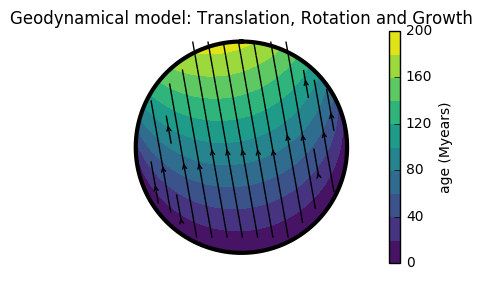

In [6]:
npoints = 100 #number of points in the x direction for the data set. 
data_set = data.PerfectSamplingEquator(npoints, rICB = 1.)
data_set.method = "bt_point"
proxy = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type="age", verbose = False)
sc = data_set.plot_c_vec(geodynModel, proxy=proxy, cm=cm, nameproxy="age (Myears)")
plt.savefig("figures/flow_Fast_translation_random.pdf", bbox_inches='tight')

## Random repartition (in the first 100km)

In [7]:
# random data set
data_set_random = data.RandomData(3000)
data_set_random.method = "bt_point"

proxy_random = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type="age", verbose=False)
## domain size and Vp
geodynModel.proxy_type = "domain_size"
proxy_random_size = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type="domain_size", verbose=False)
geodynModel.proxy_type = "dV_V"
proxy_random_dV = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type="dV_V", verbose=False)

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is age
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is domain_size
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is dV_V
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===


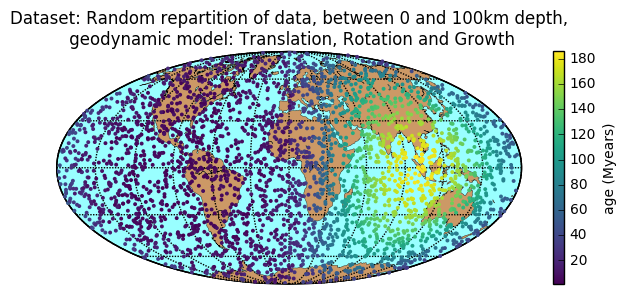

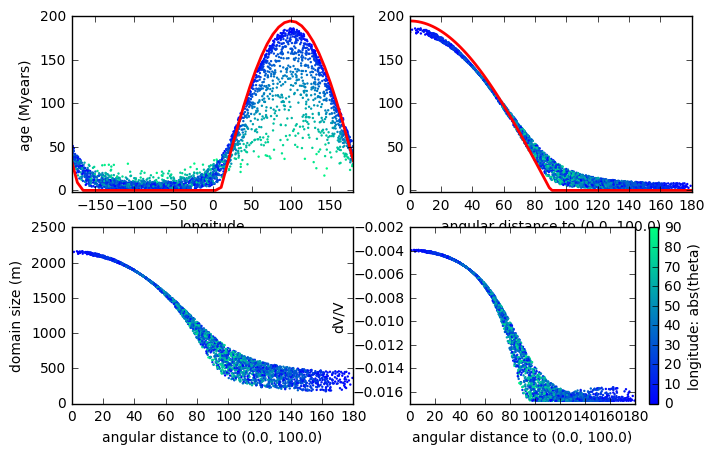

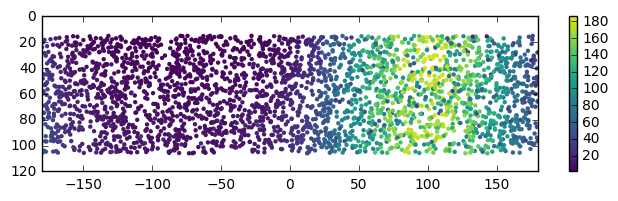

In [8]:
r, t, p = data_set_random.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

## map
m, fig = plot_data.setting_map() 
cm3 = plt.cm.get_cmap('RdYlBu')
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy_random,s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label("age (Myears)")
fig.savefig('figures/map_fast_translation_random.pdf', bbox_inches='tight')

## phi and distance plots
fig, ax = plt.subplots(2,2, figsize=(8.0, 5.0))

sc1 = ax[0,0].scatter(p, proxy_random, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
ax[0,0].set_xlabel("longitude")
ax[0,0].set_ylabel("age (Myears)")
ax[0,0].set_ylim([-2,200])
sc2 = ax[0,1].scatter(dist, proxy_random, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[0,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
ax[0,1].plot(phi+90,analytic_equator, 'r', linewidth=2)
ax[0,1].set_xlim([0,180])
ax[0,0].set_xlim([-180,180])
#fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
ax[0,1].set_ylim([-2,200])
sc3 = ax[1,0].scatter(dist, proxy_random_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90, s=3, linewidth=0)
ax[1,0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1,0].set_ylabel("domain size (m)")
ax[1,0].set_xlim([0,180])
ax[1,0].set_ylim([0, 2500.000])
sc4 = ax[1,1].scatter(dist, proxy_random_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[1,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1,1].set_ylabel("dV/V")
ax[1,1].set_xlim([0,180])
ax[1,1].set_ylim([-0.017, -0.002])

fig.savefig('figures/fast_translation_random_long_dist.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=proxy_random, s=10,cmap=cm, linewidth=0)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
cbar.set_clim(0, maxAge)

fig.savefig("figures/depth_fast-translation_random.pdf", bbox_inches='tight')

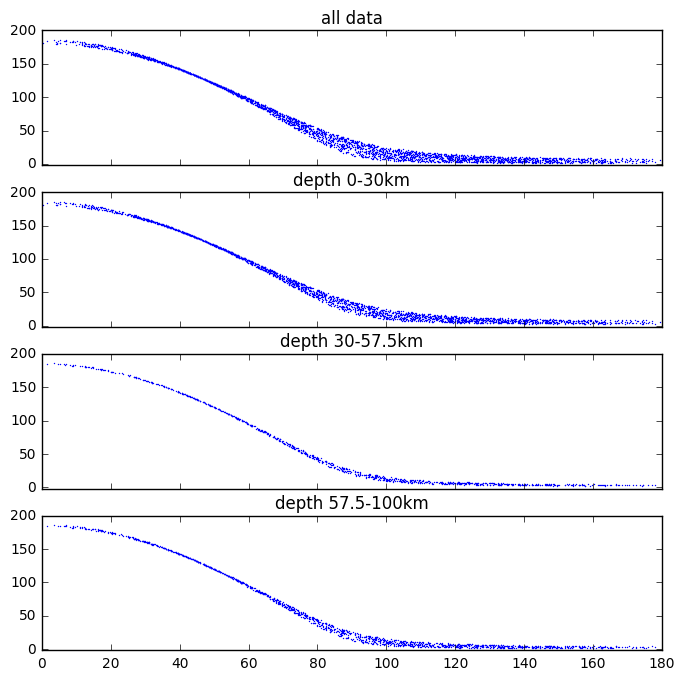

In [9]:
fig, ax = plt.subplots(4,1, sharex=True, sharey=True,figsize=(8, 8))
cm = plt.cm.get_cmap('viridis')
depth = (1-r)*1221.
ax[0].scatter(dist, proxy_random, s=1,cmap=cm, linewidth=0)
mask_0_30 = depth<30
mask_30_575 = np.ma.getmask(np.ma.masked_outside(depth,30, 57.5))
mask_575_100 = depth>57.5
#print(mask_0_30.shape, dist.shape, np.ma.array(dist, mask=mask_0_30))
ax[1].scatter(np.ma.array(dist, mask=mask_0_30), proxy_random, s=1,cmap=cm, linewidth=0)
ax[2].scatter(np.ma.array(dist, mask=mask_30_575), proxy_random, s=1,cmap=cm, linewidth=0)
ax[3].scatter(np.ma.array(dist, mask=mask_575_100), proxy_random, s=1,cmap=cm, linewidth=0)
#ax[1].scatter(np.ma.array(p,mask=mask_south),rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0.5)
#mask_north = t<-10
#ax[2].scatter(np.ma.array(p,mask=mask_north),rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0.5)
##mask_equator = np.ma.getmask(np.ma.masked_outside(t, -15,15))
#ax[3].scatter(np.ma.array(p,mask=mask_equator),rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0.5)
#fig.gca().invert_yaxis()
ax[0].set_xlim(0,180)
ax[0].set_ylim(-2,200)
ax[0].set_title("all data")
ax[1].set_title("depth 0-30km")
ax[2].set_title("depth 30-57.5km")
ax[3].set_title("depth 57.5-100km")
#fig.savefig("depth_fast-translation_Lauren.pdf", bbox_inches='tight')

## Real data from Lauren

In [10]:
## real data set
data_set2 = data.SeismicFromFile("results.dat")
data_set2.method = "bt_point"
geodynModel.proxy_type = "age"
proxy2 = geodyn.evaluate_proxy(data_set2, geodynModel, proxy_type="age", verbose=False)

## domain size and DV/V
geodynModel.proxy_type = "domain_size"
proxy2_size = geodyn.evaluate_proxy(data_set2, geodynModel, proxy_type="domain_size", verbose=False)
geodynModel.proxy_type = "dV_V"
proxy2_dV = geodyn.evaluate_proxy(data_set2, geodynModel, proxy_type="dV_V", verbose=False)

OSError: File b'results.dat' does not exist

In [ ]:
r, t, p = data_set2.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

## map
m, fig = plot_data.setting_map() 
#cm = plt.cm.get_cmap('RdYlBu')
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy2, s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set2.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label("age (Myears)")
fig.savefig('figures/map_fast_translation_Lauren.pdf', bbox_inches='tight')


## phi and distance plots
fig, ax = plt.subplots(2,2, figsize=(8.0, 5.0))

sc1 = ax[0,0].scatter(p, proxy2, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
ax[0,0].set_xlabel("longitude")
ax[0,0].set_ylabel("age (Myears)")
ax[0,0].set_ylim([-2,200])
sc2 = ax[0,1].scatter(dist, proxy2, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[0,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
ax[0,1].plot(phi+90,analytic_equator, 'r', linewidth=2)
ax[0,1].set_xlim([0,180])
ax[0,0].set_xlim([-180,180])
#fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
ax[0,1].set_ylim([-2,200])
sc3 = ax[1,0].scatter(dist, proxy2_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90, s=3, linewidth=0)
ax[1,0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1,0].set_ylabel("domain size (m)")
ax[1,0].set_xlim([0,180])
ax[1,0].set_ylim([0, 2500.000])
sc4 = ax[1,1].scatter(dist, proxy2_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[1,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1,1].set_ylabel("dV/V")
ax[1,1].set_xlim([0,180])
ax[1,1].set_ylim([-0.017, -0.002])

fig.savefig('figures/fast_translation_Lauren_long_dist.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
cbar.set_clim(0, maxAge)
cbar.set_label("age (Myears)")

fig.savefig("figures/depth_fast-translation_Lauren.pdf", bbox_inches='tight')

## Real data sets

In [ ]:
residual = data_set2.real_residual()
## map
m, fig = plot_data.setting_map() 
# cm = plt.cm.get_cmap('seismic')
x, y = m(p, t)
sc = m.scatter(x, y, c=residual, s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Real residual from Lauren's data set")
cbar1 = plt.colorbar(sc)
cbar1.set_label("Residuals")
plt.savefig("figures/map_residuals.pdf")
## phi and distance plots
fig, ax = plt.subplots(1,2, sharey=True)
cm2 = plt.cm.get_cmap('winter')
sc1 = ax[0].scatter(p, residual, c=abs(t), cmap=cm2, vmin =-0, vmax =90)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("residuals")
ax[0].set_xlim([-180, 180])
sc2 = ax[1].scatter(dist, residual, c=abs(t), cmap=cm2, vmin=-0, vmax =90)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
ax[1].set_xlim([0, 180])
fig.suptitle("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar2 = fig.colorbar(sc2)
cbar2.set_label("latitude: abs(theta)")




## Spatial repartition

In [ ]:
data1 = data.RandomData(2000)
r, t, p = data1.extract_rtp("bottom_turning_point")
fig = plt.figure()
ax = fig.add_subplot(111)
m = Basemap(projection='moll',lon_0=0.,resolution='c')
m.drawcoastlines(linewidth=0.25)
 #m.drawcountries(linewidth=0.25)
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.drawmapboundary(fill_color='#99ffff')
x, y = m(p, t)
sc = m.scatter(x, y, c='k', s=5,  zorder=10, cmap=cm, edgecolors='none')
plt.savefig("figures/map_repartition_random.pdf", bbox_inches='tight')

data2 = data.SeismicFromFile("results.dat")
r, t, p = data2.extract_rtp("bottom_turning_point")
fig = plt.figure()
ax = fig.add_subplot(111)
m = Basemap(projection='moll',lon_0=0.,resolution='c')
m.drawcoastlines(linewidth=0.25)
 #m.drawcountries(linewidth=0.25)
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.drawmapboundary(fill_color='#99ffff')
x, y = m(p, t)
sc = m.scatter(x, y, c='k', s=5,  zorder=10, cmap=cm, edgecolors='none')
plt.savefig("figures/map_repartition_Lauren.pdf", bbox_inches='tight')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

color = dist
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(p,t, c=dist>90, linewidth=0)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")


#to add histograms to see the actual repartition. Please see http://matplotlib.org/examples/axes_grid/scatter_hist.html
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)
binwidth = 10.
limX = (int(180./binwidth) + 1)*binwidth
limY = (int(90./binwidth) + 1)*binwidth
binsX = np.arange(-limX, limX + binwidth, binwidth)
binsY = np.arange(-limY, limY + binwidth, binwidth)
axHistx.hist(p, bins=binsX)
axHisty.hist(t, bins=binsY, orientation='horizontal')
#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.set_yticks([0, 100, 200, 300])
#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.set_xticks([0, 300, 600])
ax.set_aspect('equal')
ax.axis([-180, 180, -90, 90])
ax.plot([-180,180],[15,15], 'k')
ax.plot([-180,180],[-15,-15],'k')
plt.savefig("figures/t-p_repartition.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,1, sharex=True, sharey=True,figsize=(8, 8))
binwidth = 5.
lim = (int(180./binwidth) + 1)*binwidth
bins = np.arange(0, lim + binwidth, binwidth)
ax[0].hist(dist, bins=bins)
ax[0].axis([0, 180, 0, 400])
ax[0].set_title("Repartition of the rays as function of angular distance from point (100,0)")
dist_N = np.ma.array(dist, mask=t>0)
ax[1].hist(dist_N.compressed(), bins=bins)
ax[1].set_title("latitude <0 (southern hemisphere)")
dist_S = np.ma.array(dist, mask=t<0)
ax[2].hist(dist_S.compressed(), bins=bins)
ax[2].set_title("latitude >0 (northern hemisphere)")
dist_E = np.ma.array(dist, mask=np.ma.getmask(np.ma.masked_outside(t, -15,15)))
ax[3].hist(dist_E.compressed(), bins=bins)
ax[3].set_title("latitude between -15 and 15 (equator region)")

fig.savefig("figures/dist_repartition.pdf", bbox_inches='tight')

In [ ]:
## map
m, fig = plot_data.setting_map() 
# cm = plt.cm.get_cmap('seismic')
x, y = m(p, t)
sc = m.scatter(x, y, c=dist, zorder=10, cmap=cm, edgecolors='none')
cbar1 = plt.colorbar(sc)
cbar1.set_label("angular distance from (0,100)")
plt.savefig("figures/map_dist_Lauren_repartition.pdf")

In [ ]:
fig, ax = plt.subplots(4,1, sharex=True, sharey=True,figsize=(8, 8))
# cm = plt.cm.get_cmap('seismic')
ax[0].scatter(p,rICB_dim*(1.-r), c=residual, s=10,cmap=cm, linewidth=0.5)
mask_south = t>10
ax[1].scatter(np.ma.array(p,mask=mask_south),rICB_dim*(1.-r), c=residual, s=10,cmap=cm, linewidth=0.5)
mask_north = t<-10
ax[2].scatter(np.ma.array(p,mask=mask_north),rICB_dim*(1.-r), c=residual, s=10,cmap=cm, linewidth=0.5)
mask_equator = np.ma.getmask(np.ma.masked_outside(t, -15,15))
ax[3].scatter(np.ma.array(p,mask=mask_equator),rICB_dim*(1.-r), c=residual, s=10,cmap=cm, linewidth=0.5)
fig.gca().invert_yaxis()
ax[0].set_xlim(-180,180)
ax[0].set_title("All data")
ax[1].set_title("South")
ax[2].set_title("North")
ax[3].set_title("Equator region")
plt.savefig("./figures/phi-depth.pdf")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(residual, proxy2, c=dist)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=t, s=10,cmap=plt.cm.get_cmap('seismic'), linewidth=0.1)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
cbar.set_label("longitude: abs(theta)")
#cbar.set_clim(0, maxAge)

fig.savefig("figures/repartition_Lauren_depth_latitude.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=t, s=10,cmap=cm, linewidth=0)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
cbar.set_label("latitude: abs(theta)")


## Spatial repartition

## meshgrid of the equatorial upper part

In [ ]:
data_meshgrid = data.Equator_upperpart(150,150)
data_meshgrid.method = "bt_point"
proxy_meshgrid = geodyn.evaluate_proxy(data_meshgrid, geodynModel, proxy_type="age", verbose = False)
r, t, p = data_meshgrid.extract_rtp("bottom_turning_point")

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 2))
X, Y, Z  = data_meshgrid.mesh_RPProxy(proxy_meshgrid)
sc = ax3.contourf(Y, rICB_dim*(1.-X), Z, 100, cmap=cm)
sc2 = ax3.contour(sc, levels=sc.levels[::15], colors = "k")
ax3.set_ylim(-0, 120)
fig3.gca().invert_yaxis()
ax3.set_xlim(-180,180)
cbar = fig3.colorbar(sc)
#cbar.set_clim(0, maxAge)
cbar.set_label("age (Myears)")

plt.savefig("figures/meshgrid_fasttranslation.pdf", bbox_inches='tight')